In [1]:
import os
# Set environment variables to help manage CUDA memory
os.environ['CUDA_VISIBLE_DEVICES'] = "MIG-214cfb66-c8e5-57f2-b101-90f2cca83fad"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import re
import glob
import yaml
import warnings
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
pl.seed_everything(42)

from dataset import E3OMA
from model import STMLightning
from utils import qqplot, find_nearest

import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Seed set to 42
/home/serfani/miniforge3/envs/Lightning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/serfani/miniforge3/envs/Lightning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /home/serfani/miniforge3/envs/Lightning/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/serfani/miniforge3/envs/Lightning/share/proj failed


In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA A100 80GB PCIe MIG 4g.40gb


In [4]:
def natural_sort_key(s):
    # Split the string into segments of digits and non-digits
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

models_path_root = '/home/serfani/serfani_data1/snapshots'
# List directory contents
dir_contents = os.listdir(models_path_root)

# Sort using the custom sort key
sorted_contents = sorted(dir_contents, key=natural_sort_key)

# Print sorted contents
for idx, model in enumerate(sorted_contents):
    print(idx, model)

0 Conv3D-03122025-1601
1 Conv3D-03122025-1651
2 Conv3D-03142025-1002
3 Conv3D-03192025-1113
4 Conv3D-06232025-1505
5 ConvLSTM-02102025-1714
6 ConvLSTM-03122025-1209
7 ConvLSTM-03122025-1308
8 ConvLSTM-03242025-1200
9 ConvLSTM-04152025-1359
10 ConvLSTM-04292025-1357
11 ConvLSTM-06112025-1135
12 ConvLSTM-06232025-0935
13 ConvLSTM-06262025-0935
14 ConvLSTM-07032025-1434
15 ConvLSTM-07032025-1434V01
16 ConvLSTM-07132025-0158
17 ConvLSTM-07142025-1306
18 ConvLSTM-07142025-2256
19 ConvLSTM-07252025-1640
20 LSTM-64K5.32K3.16K3-E33OMA90D-5C-BCB-20241014-1247
21 LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
22 LSTM-64K5.32K3.16K3-E33OMA-8C-BCB-20240719-1241
23 SimVP-02132025-1532
24 UNet-E33OMA-5C-BCB-20240718-1527


In [5]:
model_index = 19
model_name  = sorted_contents[model_index]

save_figure = True

# Read the YAML/CKPT files
snapshot_dir = os.path.join(models_path_root, model_name)
config_filepath = glob.glob(os.path.join(snapshot_dir, "version_*", "hparams.yaml"))[0]
checkpoint_path = glob.glob(os.path.join(snapshot_dir, "version_*", "checkpoints", "*.ckpt"))[0]

with open(config_filepath, 'r') as config_file:
    hyperparams = yaml.load(config_file, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

# Print dynamically created variables
for cat in ['model_args', 'data_args']:
    print(f'{cat}:')
    for key, value in hyperparams[cat].items():
        print(f'{key}: {value}')
    print()

model_args:
encoder_channels: [64, 64, 64]
epochs: 30
in_channels: 64
kernel_size: [3, 3, 3]
learning_rate: 0.0001
log_dir: /home/serfani/serfani_data1/snapshots
log_name: ConvLSTM-07252025-1640
loss: ['MSE', 'MAE']
model_name: ConvLSTM
optimizer: Adam
out_channels: 20
scheduler: CosineAnnealingLR
scheduler_params: {'cosine_scheduler': {'T_max': 30}}
weight_decay: 0.0

data_args:
batch_size: 4
data_name: E3OMA2010D
levels: 20
num_workers: 4
padding: [5, 5]
sequence_length: 48
size: [90, 144]
species: bcb



### Load Dataset and Model

In [6]:
dataset = E3OMA(period='test', species=data_args['species'], padding=data_args['padding'], levels=data_args['levels'], sequence_length=data_args['sequence_length'],
                zarr_path=f'/home/serfani/serfani_data0/{data_args["data_name"]}.zarr')
dataloader = DataLoader(dataset, batch_size=4, shuffle=False , num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [6]:
net = STMLightning.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_args=model_args,
    data_args=data_args
)
net.eval()

STMLightning(
  (model): Model(
    (encoder): FMEncoder(
      (enc1): Encoder(
        (conv0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
          (dropout): Identity()
        )
        (conv2): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
          (dropout): Identity()
        )
      )
      (enc2): Encoder(
        (conv0): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
          (dropout): Identity()
        )
       

### Inference Phase

In [8]:
from tqdm import tqdm

# Preallocation
total_samples = len(dataloader.dataset)
GTs = torch.empty((total_samples, 1, 1, data_args['levels'], data_args['size'][0], data_args['size'][1]), dtype=torch.float32)
PDs = torch.empty((total_samples, 1, 1, data_args['levels'], data_args['size'][0], data_args['size'][1]), dtype=torch.float32)

y_avg = torch.tensor(dataset.y_mean, dtype=torch.float32).cuda()
y_std = torch.tensor(dataset.y_std, dtype=torch.float32).cuda()

sample_index = 0
with torch.no_grad():
    # Add tqdm wrapper around dataloader
    for counter, (X2D, X3D, y) in enumerate(tqdm(dataloader, desc="Processing batches"), 1):

        batch_size = X2D.shape[0]

        X2D = X2D.cuda(non_blocking=True)      
        X3D = X3D.cuda(non_blocking=True)      
        y = y.cuda(non_blocking=True)

        p = net(X2D, X3D)
        p = p[..., 
                  data_args['padding'][0]:data_args['padding'][0]+data_args['size'][0], 
                  data_args['padding'][1]:data_args['padding'][1]+data_args['size'][1]]

        GTs[sample_index:sample_index+batch_size] = (y * y_std) + y_avg
        PDs[sample_index:sample_index+batch_size] = (p * y_std) + y_avg
        
        sample_index += batch_size

GTs = GTs.cpu().numpy()
PDs = PDs.cpu().numpy()

print(GTs.shape, PDs.shape)

Processing batches: 100%|██████████| 8749/8749 [12:21:35<00:00,  5.09s/it]    

(34993, 1, 1, 20, 90, 144) (34993, 1, 1, 20, 90, 144)


In [ ]:
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode = 'wb') as f:

    np.save(f, GTs)
    np.save(f, PDs)

In [7]:
with open(os.path.join(snapshot_dir, 'test-results-2020.npy'), mode='rb') as f:
    
    GTs = np.load(f, allow_pickle=True)
    PDs = np.load(f, allow_pickle=True)

print(GTs.shape, PDs.shape)

(34993, 1, 1, 20, 90, 144) (34993, 1, 1, 20, 90, 144)


### Converting Units from Mixing Ratio to Concentration

In [ ]:
# ds2 = xr.open_zarr(f'/home/serfani/serfani_data0/E3OMA2020D.zarr', consolidated=True)
ds2 = xr.open_zarr(f'/home/serfani/serfani_data0/{data_args["data_name"]}.zarr', consolidated=True)
ds2 = ds2.isel(time=slice(-17520, None))

ds2

<xarray.Dataset> Size: 498GB
Dimensions:          (time: 35040, lat: 90, lon: 144, level: 30)
Coordinates:
  * level            (level) float32 120B 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
  * lat              (lat) float32 360B -90.0 -87.0 -85.0 ... 85.0 87.0 90.0
  * lon              (lon) float32 576B -178.8 -176.2 -173.8 ... 176.2 178.8
  * time             (time) datetime64[ns] 280kB 2020-01-01T00:15:00 ... 2021...
Data variables: (12/15)
    shflx            (time, lat, lon) float32 2GB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    th               (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    u                (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    lhflx            (time, lat, lon) float32 2GB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    landfr           (lat, lon) float32 52kB dask.array<chunksize=(90, 144), meta=np.ndarray>
    axyp             (lat, lon) float32 52kB dask.array<chunksize=(90, 144), meta=np.ndarray>
    ...               ...
    prec_3d_sum      (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    pblht_bp         (time, lat, lon) float32 2GB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    BCB              (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    t                (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    omega            (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
    q                (time, level, lat, lon) float32 54GB dask.array<chunksize=(48, 30, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E33oma_ai (OMA rundeck purely for initial coding of washout/aqc...
    fromto:   From:  1950  JAN  1,  Hr  0      To:  1951  JAN  1, Hr  0  Mode...

In [9]:
pressure = ds2['p_3d'].isel(level=slice(0, data_args['levels'])).values * 100 # Convert pressure from hectopascals (hPa) to pascals (Pa).
temperature = ds2['t'].isel(level=slice(0, data_args['levels'])).values       # Temperature in Kelvin (K)

R_d = 287.055 # Specific gas constant for dry air in J/(kg·K)
rho = pressure[47:] / (R_d * temperature[47:]) # Calculate air density in kg/m^3

GTs = GTs.squeeze() * 0.01 * rho # Convert from mixing ratio (kg/kg_air x 10^-11) to micrograms per cubic meter (μg/m^3) 
PDs = PDs.squeeze() * 0.01 * rho # Convert from mixing ratio (kg/kg_air x 10^-11) to micrograms per cubic meter (μg/m^3)
print(GTs.shape, PDs.shape)

(34993, 20, 90, 144) (34993, 20, 90, 144)


In [10]:
def r_squared_temporal(gts, pds, level):
    gts = gts[:, level, :, :]
    pds = pds[:, level, :, :]
    
    # Preallocate arrays for metrics
    r_squared_temporal = np.empty((gts.shape[0]))
    pearsonr_temporal = np.empty((gts.shape[0]))
    mae_temporal = np.empty((gts.shape[0]))
    rmse_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())
        pearsonr_temporal[i], _ = pearsonr(gt.flatten(), pds[i].flatten())
        mae_temporal[i] = mean_absolute_error(gt.flatten(), pds[i].flatten())
        rmse_temporal[i] = np.sqrt(root_mean_squared_error(gt.flatten(), pds[i].flatten()))

    return pd.DataFrame({
        'r_squared': r_squared_temporal,
        'pearsonr': pearsonr_temporal,
        'mae': mae_temporal,
        'rmse': rmse_temporal
    })

In [11]:
level = 0
# Assuming r_squared_temporal(GTs, PDs) returns a DataFrame
result = r_squared_temporal(GTs, PDs, level).describe()

# Save the result to a text file
with open(os.path.join(snapshot_dir, 'metrics-2020.txt'), 'w') as file:
    file.write(result.to_string())

result

,r_squared,pearsonr,mae,rmse
count,34993.000000,34993.000000,34993.000000,34993.000000
mean,0.816278,0.918176,0.013751,0.311111
std,0.146129,0.063385,0.021042,0.296185
min,-0.522460,0.436658,0.001946,0.100346
25%,0.780688,0.899418,0.004316,0.168352
50%,0.859477,0.935593,0.006181,0.214590
75%,0.908619,0.959046,0.014659,0.322416
max,0.985409,0.993362,0.350403,3.551785


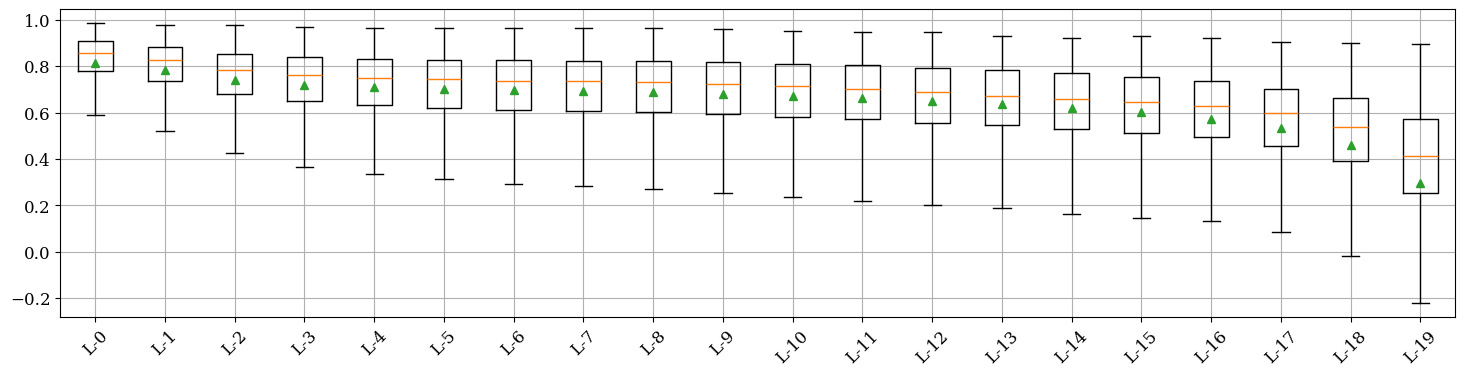

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))

num_levels = 20  # Adjust as needed

boxplot_data = [
    r_squared_temporal(GTs, PDs, level)['r_squared'].values
    for level in range(num_levels)
]
boxplot_xticklabels = [f'L-{level}' for level in range(num_levels)]

ax.boxplot(boxplot_data, showmeans=True, showfliers=False)
ax.set_xticklabels(boxplot_xticklabels, rotation=45)

ax.grid()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'01-{data_args["data_name"]}-Rsquared-boxplot.png'))

plt.show()

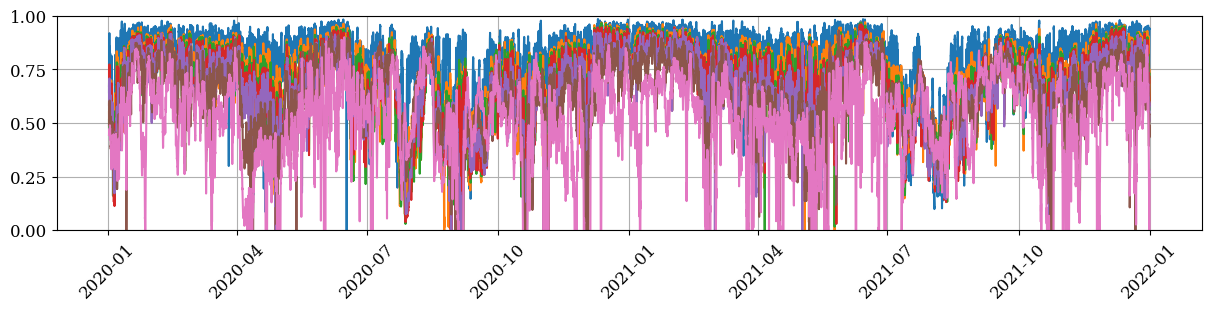

In [ ]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

fig, ax3 = plt.subplots(ncols=1, figsize=(12, 3), constrained_layout=True)

time = dataset.datetimeindex[:]

levels_to_plot = [0, 3, 6, 9, 12, 15, 18]
level_data = [boxplot_data[level] for level in levels_to_plot]
level_labels = [f'Level-{level}' for level in levels_to_plot]

# Use matplotlib's color cycle for as many lines as needed
color_cycle = plt.cm.tab10.colors  # or plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (data, label) in enumerate(zip(level_data, level_labels)):
    color = color_cycle[i % len(color_cycle)]
    ax3.plot(time, data, label=label, color=color)

ax3.tick_params(axis='x', labelrotation=45)
ax3.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax3.set_ylim([0, 1])
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax3.grid()

# ax3.legend()  # Uncomment if you want the legend
plt.show()

In [13]:
# Define the r_squared_spatial function
def r_squared_spatial(real_data, model_output):
    # Calculate the coefficient of determination (R^2)
    ss_res = np.sum((real_data - model_output) ** 2, axis=0)
    ss_tot = np.sum((real_data - np.mean(real_data, axis=0)) ** 2, axis=0)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [14]:
sr2 = r_squared_spatial(GTs, PDs)
sr2.shape

(20, 90, 144)

In [ ]:
ds = xr.Dataset({
    'Real Data': (["time", "level", "lat", "lon"], GTs),
    'Model Output': (["time", "level", "lat", "lon"], PDs),
    'Coefficient of Determination': (["level", "lat", "lon"], sr2),

              },
              
     coords=dict(
        time = dataset.datetimeindex,
        level = np.arange(dataset.levels),
        lon  = dataset.lon,
        lat  = dataset.lat,
    )
)
ds

<xarray.Dataset> Size: 73GB
Dimensions:                       (time: 34993, level: 20, lat: 90, lon: 144)
Coordinates:
  * lon                           (lon) float32 576B -178.8 -176.2 ... 178.8
  * lat                           (lat) float32 360B -90.0 -87.0 ... 87.0 90.0
  * time                          (time) datetime64[ns] 280kB 2020-01-01T23:4...
  * level                         (level) int64 160B 0 1 2 3 4 ... 16 17 18 19
Data variables:
    Real Data                     (time, level, lat, lon) float32 36GB 6.091e...
    Model Output                  (time, level, lat, lon) float32 36GB 4.745e...
    Coefficient of Determination  (level, lat, lon) float32 1MB -1.352 ... -0...

In [24]:
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_avg = ds[['Real Data', 'Model Output']].weighted(weights).mean(dim=("lat", "lon", "time"))

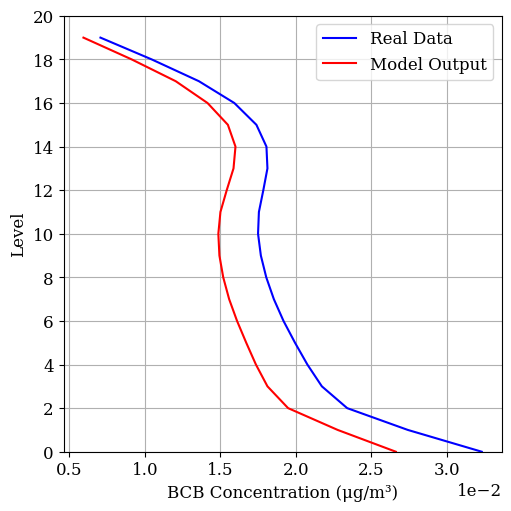

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), constrained_layout=True)

ds_avg['Real Data'].plot(ax=ax, y='level', yincrease=True, label='Real Data', color='blue')
ds_avg['Model Output'].plot(ax=ax, y='level', yincrease=True, label='Model Output', color='red')

ax.set_xlabel('BCB Concentration (μg/m³)')

ax.set_ylabel('Level')
ax.set_ylim(0, 19)  # Set y-axis range from 1 to 20
ax.set_yticks(range(0, 21, 2))  # Set integer ticks from 1 to 20
ax.grid()

# Set x-axis to scientific notation
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.legend()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'02-{data_args["data_name"]}-BCBConc-overall.png'))

plt.show()

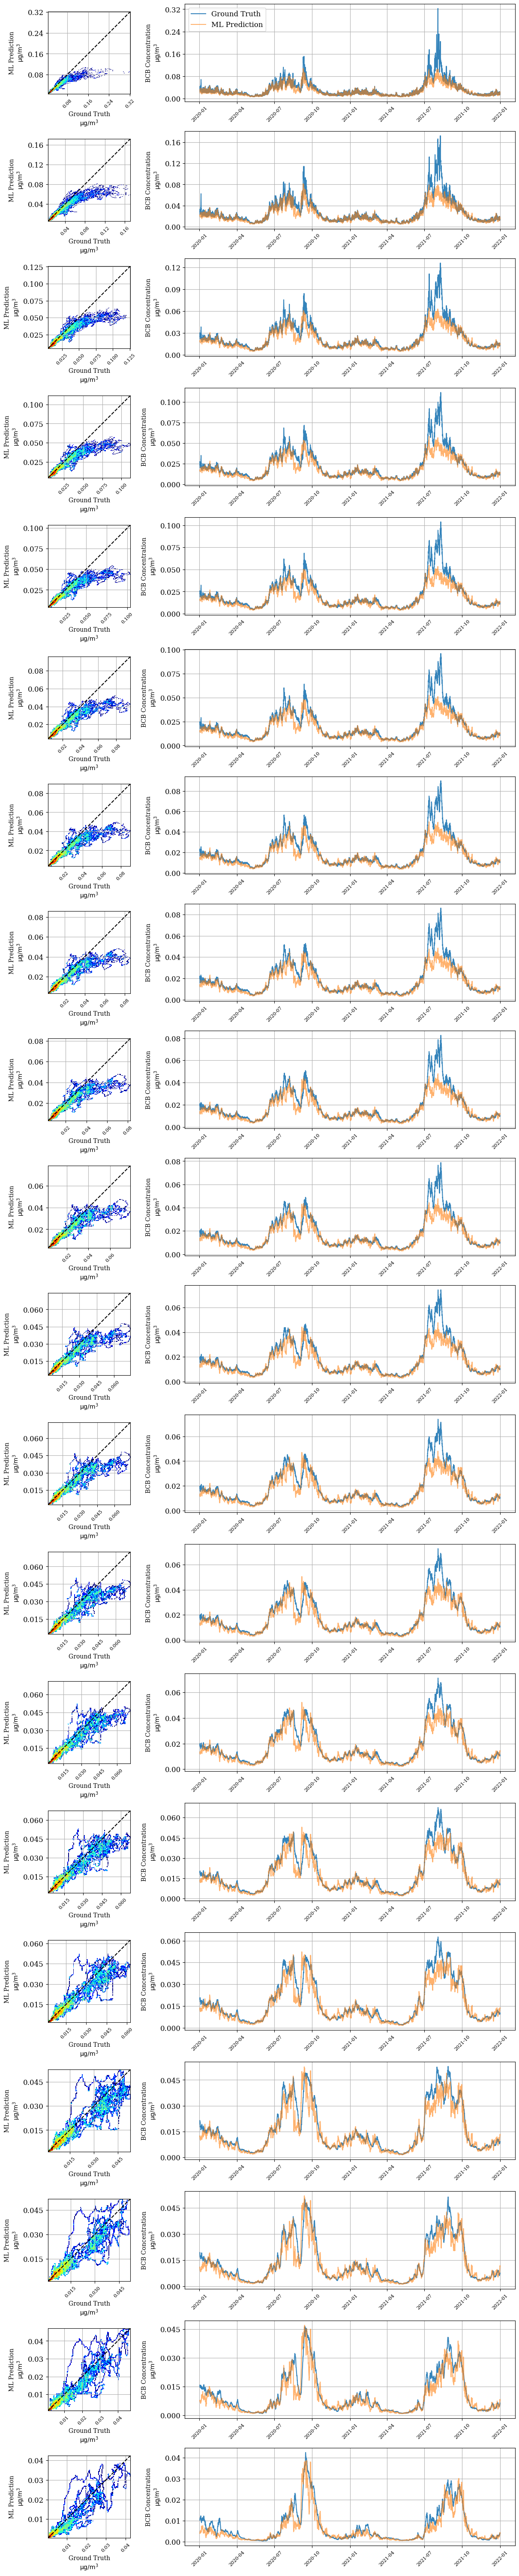

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib import colors  # Add this import

num_levels = ds.level.size

fig, axes = plt.subplots(
    nrows=num_levels, ncols=2, 
    figsize=(12, 3*num_levels), 
    constrained_layout=True, 
    gridspec_kw={'width_ratios':[1, 4]}
)

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"
ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))

for level in range(num_levels):
    ax1, ax3 = axes[level]

    avgGT = ds_avg['Real Data'].isel(level=level).values
    avgPD = ds_avg['Model Output'].isel(level=level).values

    max_value = np.array((avgGT, avgPD)).max()
    min_value = np.array((avgGT, avgPD)).min()

    # Hist2d plot
    ax1.hist2d(avgGT.ravel(), avgPD.ravel(), bins=100, norm=colors.LogNorm(), cmap='jet')
    # ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
    
    # Set equal axis limits - this is the key addition
    ax1.set_aspect('equal')
    ax1.set_xlim(min_value, max_value)
    ax1.set_ylim(min_value, max_value)
    
    ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=10)
    ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=10)
    ax1.grid()

    # Time series plot
    ax3.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
    ax3.plot(dataset.datetimeindex, avgPD, alpha=0.6, label='ML Prediction')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
    ax3.set_ylabel(r'BCB Concentration' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=10)
    ax3.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax3.grid()
    if level == 0:
        ax3.legend()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'03-{data_args["data_name"]}-GlobalAverage.png'))

plt.show()

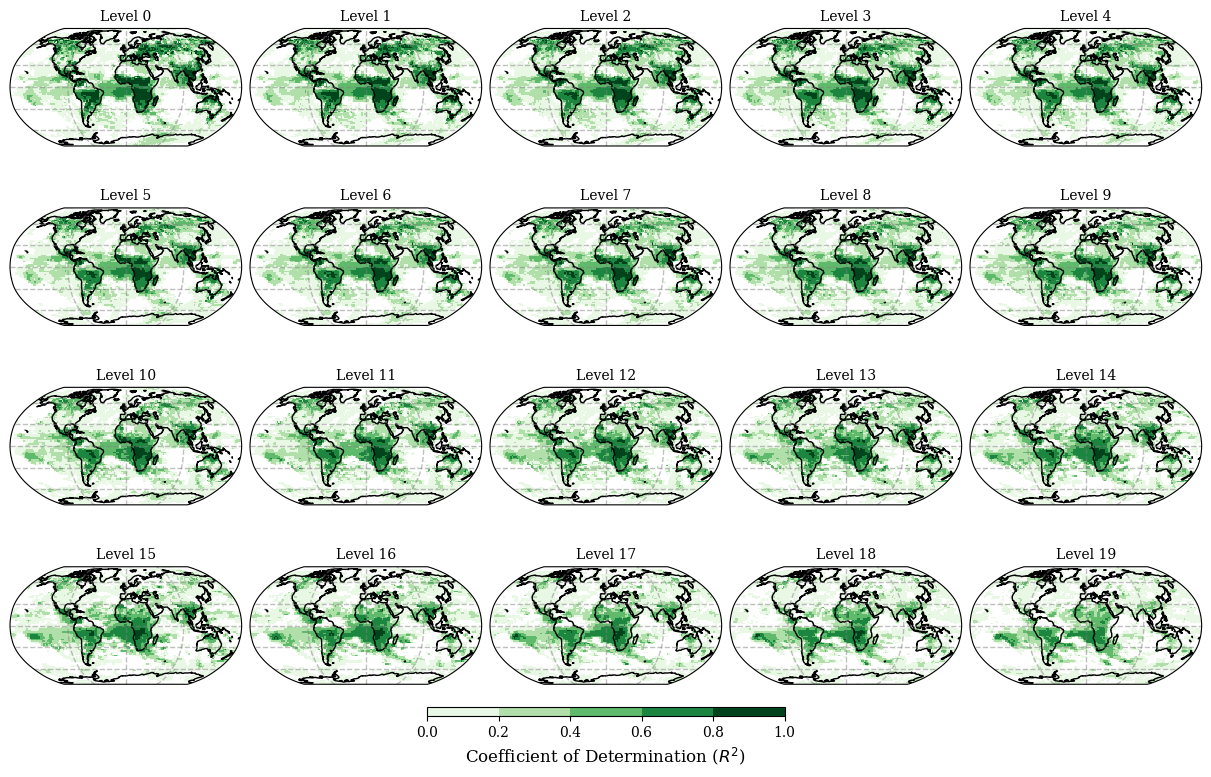

In [ ]:
nrows, ncols = 4, 5
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(12, 8), 
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

colors = plt.cm.Greens(np.linspace(0.1, 1, 5))
bounds = np.linspace(0, 1, 6)
cmap = mcolors.ListedColormap(colors)
cmap.set_bad((0.5, 0.5, 0.5, 0))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

lon, lat = np.meshgrid(ds['lon'], ds['lat'])

for level in range(nrows * ncols):
    ax = axes.flat[level]
    ax.coastlines()
    data = ds['Coefficient of Determination'].isel(level=level).values
    data = np.where(data < 0, np.nan, data)
    im = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm,
    )
    ax.set_title(f'Level {level}', fontsize=10)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])

    # Individual colorbar for each subplot (optional, can be slow)
    # cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
    # cbar.set_label(r'$R^2$', rotation=0, labelpad=5, fontsize=8)
    # cbar.ax.tick_params(labelsize=8)

# Shared colorbar for all subplots
cbar = fig.colorbar(
    im, ax=axes, orientation='horizontal', pad=0.03, shrink=0.3, 
    aspect=40, fraction=0.05
)
cbar.set_label(r'Coefficient of Determination ($R^2$)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'04-{data_args["data_name"]}-Rsquared-SpatialDist.png'))

plt.show()

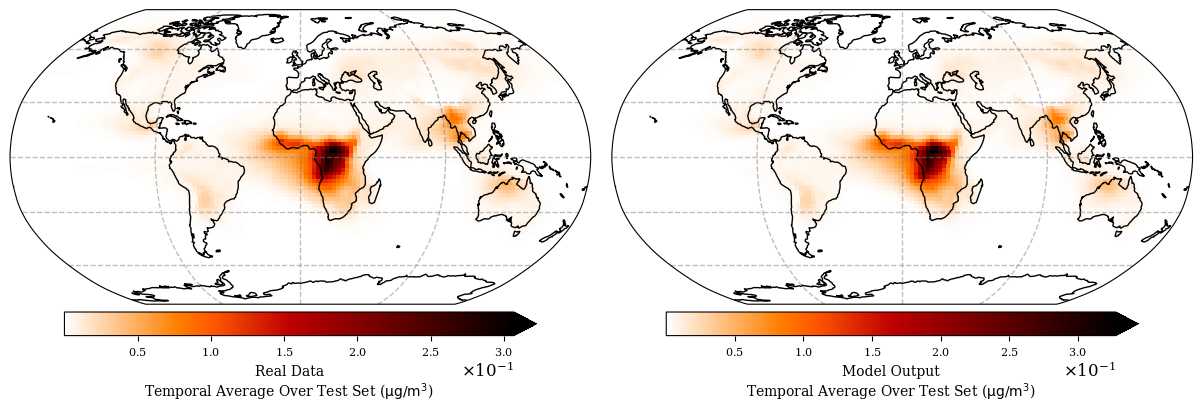

In [31]:
level = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.coastlines()

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').isel(level=level).values

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
# bounds[1] = 0.01
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im1 = ax1.pcolormesh(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
)

# im1 = ax1.contourf(
#     lon, lat, data1,
#     transform=ccrs.PlateCarree(),
#     levels=bounds, 
#     cmap=cmap, norm=norm, extend='max'
# )


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl1.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

ax2.coastlines()

# Get the data for the current level
data2 = ds['Model Output'].mean(dim='time').isel(level=level).values

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im2 = ax2.pcolormesh(
    lon, lat, data2,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
)

# im2 = ax2.contourf(
#     lon, lat, data2,
#     transform=ccrs.PlateCarree(),
#     levels=bounds, 
#     cmap=cmap, norm=norm, extend='max'
# )

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl2.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Model Output' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)


if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '05-annual_average.png'))

plt.show()

In [29]:
# GFED (global fire emissions database) regions
gfed = {
    "BONA": [50, 70, -170, -50],
    "TENA": [25, 50, -170, -50],
    "CEAM": [0, 25, -120, -60],
    "NHSA": [-10, 0, -85, -35],
    "SHSA": [-55, -10, -85, -35],
    "EURO": [35, 70, -10, 60],
    "MIDE": [15, 45, 30, 70],
    "NHAF": [0, 15, -20, 50],
    "SHAF": [-35, -10, -20, 50],
    "BOAS": [50, 70, 60, 180],
    "CEAS": [30, 50, 60, 120],
    "SEAS": [15, 25, 75, 115],
    "EQAS": [-10, 10, 95, 150],
    "AUST": [-50, -10, 110, 180],
}
gfed_ds = xr.open_dataset('./dev/basis_regions_regridded.nc')

In [22]:
gfed_ds

<xarray.Dataset> Size: 105kB
Dimensions:        (lat: 90, lon: 144)
Coordinates:
  * lat            (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 85.0 87.0 90.0
  * lon            (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Data variables:
    basis_regions  (lat, lon) float64 104kB ...

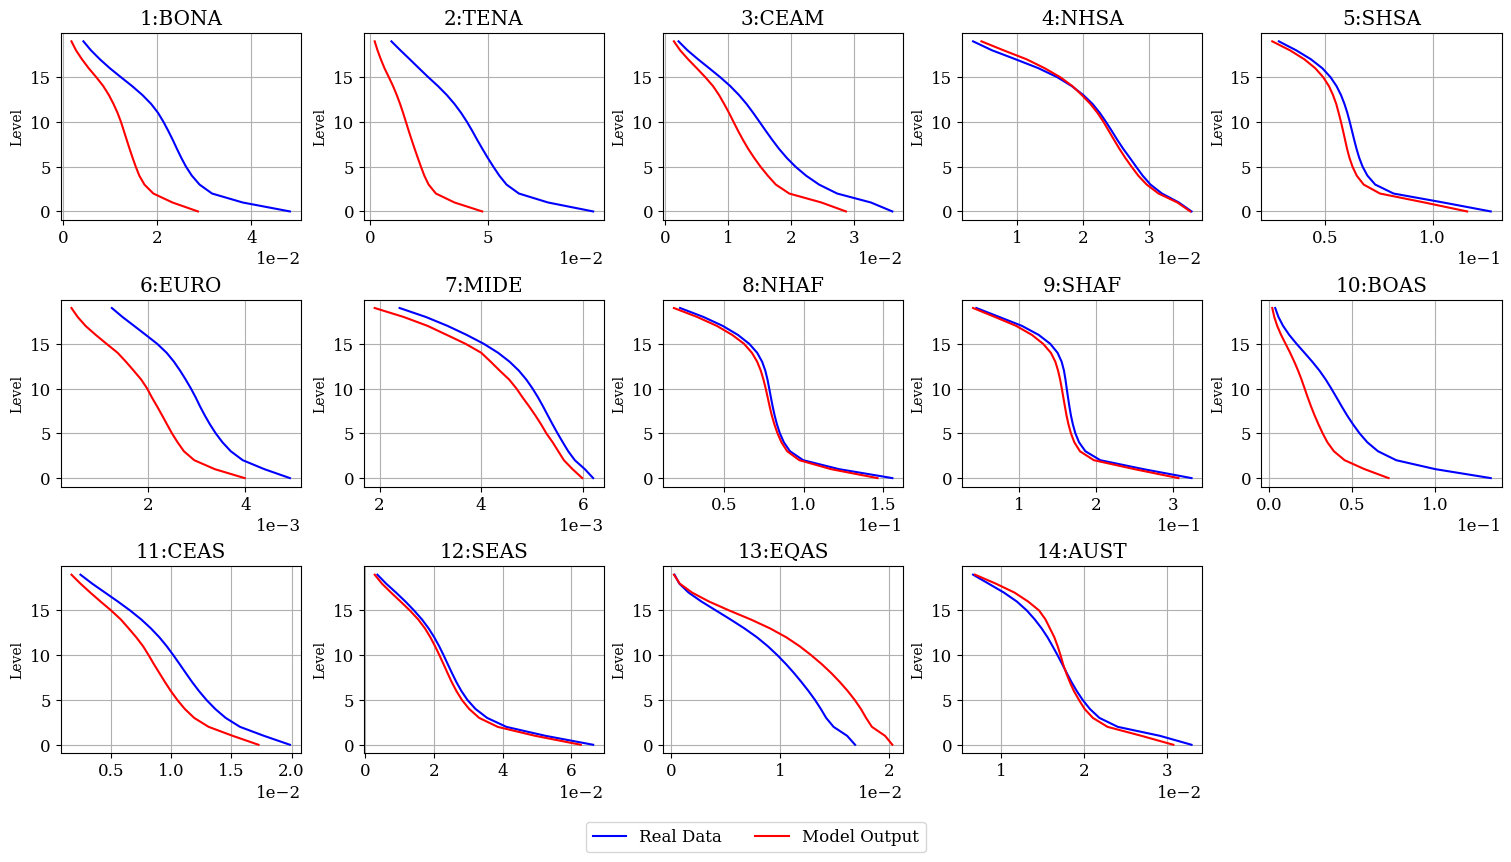

In [ ]:

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 8), constrained_layout=True)
axs = axs.flatten()

ds_avg = ds[['Real Data', 'Model Output']].mean(dim=("time"))
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

for i, (name, (_, _, _, _)) in enumerate(gfed.items(), 1):

    avgGT = ds_avg['Real Data'].where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))
    avgPD = ds_avg['Model Output'].where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))

    avgGT.plot(ax=axs[i-1], y='level', yincrease=True, label='Real Data', color='blue')
    avgPD.plot(ax=axs[i-1], y='level', yincrease=True, label='Model Output', color='red')

    axs[i-1].set_ylabel('Level', fontsize=10)
    axs[i-1].set_xlabel('', fontsize=10)
    axs[i-1].set_title(f'{i}:{name}')
    axs[i-1].grid()

    axs[i-1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    axs[14].set_visible(False)

# Get handles and labels from any subplot (they're all the same)
handles, labels = axs[0].get_legend_handles_labels()

# Create a figure-level legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'05-{data_args["data_name"]}-GFED-RegionalAnalysis.png'))

plt.show()

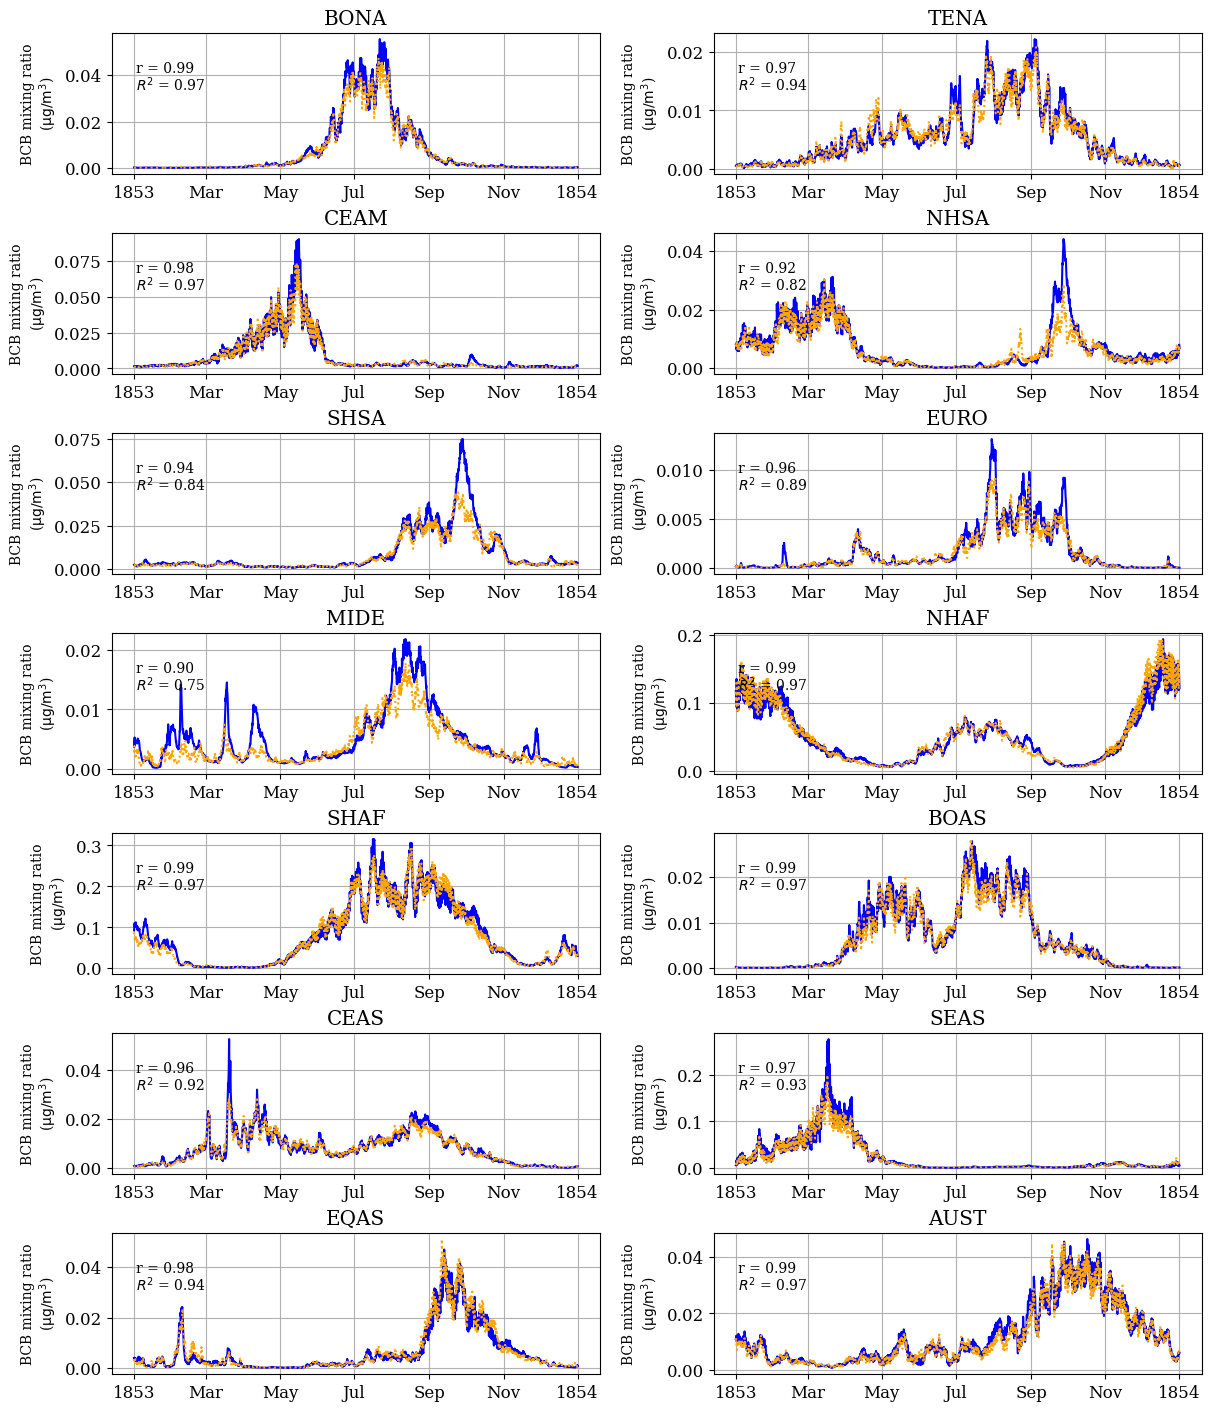

In [46]:
level = 10

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 14), constrained_layout=True)
axs = axs.flatten()

for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    avgGT = ds['Real Data'].isel(level=level).where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))
    avgPD = ds['Model Output'].isel(level=level).where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))

    corr, _ = pearsonr(avgGT.values, avgPD.values)
    nse = r2_score(avgGT.values, avgPD.values)

    axs[i-1].text(0.05, 0.80, rf'r = {corr:.2f}', transform=axs[i-1].transAxes, fontsize=10, va='top', ha='left')
    axs[i-1].text(0.05, 0.70, rf'$R^2$ = {nse:.2f}', transform=axs[i-1].transAxes, fontsize=10, va='top', ha='left')

    # Plot the data

    avgGT.plot(ax=axs[i-1], label='Real Data', color='blue')
    avgPD.plot(ax=axs[i-1], label='Model Output', color='orange', linestyle=':')

    axs[i-1].set_xlabel('', fontsize=10)
    axs[i-1].set_ylabel(r'BCB mixing ratio' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=10)

    axs[i-1].set_title(name)
    # axs[i-1].legend(fontsize=10)

    axs[i-1].grid()

plt.show()

In [ ]:
level = 0

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.set_global()

# Get the data for the current level
data1 = ds['Real Data'].isel(level=level).mean(dim='time').values

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)

ax1.add_feature(cfeature.COASTLINE, linestyle='--')
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add boxes and labels
for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):
    rect = patches.Rectangle(
        (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
        linewidth=1.5, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree()
    )
    ax1.add_patch(rect)
    ax1.text(
        (lon_min + lon_max) / 2, (lat_min + lat_max) / 2, f"{name}",
        transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks

plt.show()

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Read basis_regions from HDF5
with h5py.File('GFED4.1s_2000.hdf5', 'r') as file:
    basis_regions = file['ancill']['basis_regions'][:]
    lats = -file['lat'][:][:, 0]
    lons = file['lon'][:][0, :]

# Flip vertically for geographic orientation
basis_regions_flipped = np.flipud(basis_regions)

# Create xarray Dataset
ds_basis = xr.DataArray(
    basis_regions_flipped,
    dims=("lat", "lon"),
    coords={"lat": lats, "lon": lons},
    name="basis_regions"
).to_dataset()

# Save to NetCDF
ds_basis.to_netcdf("basis_regions.nc")

# --- Regridding ---
basis_regions_regridded = ds_basis.interp(
    lat=ds.lat,
    lon=ds.lon,
    method="nearest"
)

# Save to NetCDF
basis_regions_regridded.to_netcdf("basis_regions_regridded.nc")

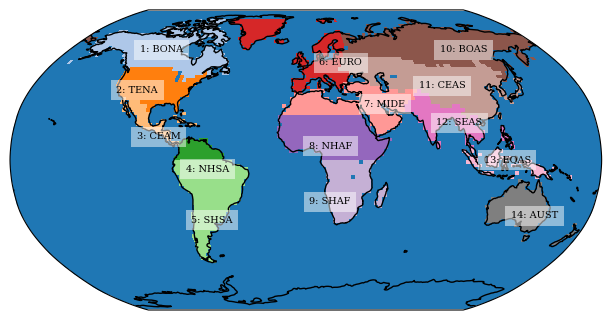

In [43]:
# Create a 15-color colormap from tab20
from matplotlib.colors import ListedColormap
cmap15 = ListedColormap(plt.get_cmap('tab20').colors[:15])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax.set_global()
ax.coastlines() 

gfed_ds['basis_regions'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap15,
    add_colorbar=False,
    # cbar_kwargs={'label': 'Basis Regions', 'shrink': 0.8}
)


for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):
    rect = patches.Rectangle(
        (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
        linewidth=1.5, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree()
    )
    # ax.add_patch(rect)
    ax.text(
        (lon_min + lon_max) / 2, (lat_min + lat_max) / 2, f"{i}: {name}",
        transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=7,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )


plt.show()